# Reference
[RNN을 사용한 텍스트 분류](https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ko)

# Workflow
1. EDA
2. RNN
3. Stacked RNN

# 1. EDA



### Data: IMDB 영화리뷰

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

데이터는 단어 인덱싱 전처리가 된 데이터

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5UIINN/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5UIINN/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5UIINN/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
test_dataset2 = dataset['test']

In [5]:
for i in train_dataset.take(1):
    print('input', i[0])
    print('output', i[1])

input tf.Tensor(
[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975], shape=(163,), dtype=int64)
output tf.Tensor(0, shape=(), dtype=int64)


` tfds.features.text.SubwordTextEncoder`를 이용하여 사전에 만들어진 subwords encoder 

In [ ]:
encoder = info.features['text'].encoder

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [ ]:
encoder.subwords[:5]

['the_', ', ', '. ', 'a_', 'and_']

In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


##### assert: 가정 설정문

In [ ]:
assert original_string == sample_string
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


# 2. LSTM

RNN은 전통적인 RNN 구조와 LSTM, GRU와 같은 발전된 구조 등이 사용된다. 그 중에서 LSTM은 가장 널리 쓰이는 구조로써, 입력 Sequence가 길어짐에 따라 발생하는 과거 데이터 정보 기억을 보완해주는 기능을 담당한다.

RNN의 경우, 출력값을 조절할 수 있다. 마지막 Sequence에만 출력값이 있는 many-to-one과 모든 Sequence에 출력값이 있는 many-to-many와 같이 다양한 network를 만들 수 있다


**many_to_one**
- return_sequences = True
  - LSTM layer의 출력값이 한개
  - many-to-many
  - output: `(batch_Size, units)`

**many_to_many**  
- return_sequences = False 
  - LSTM layer의 출력값이 한개
  - many-to-one
  - output: `(batch_Size, timesteps, units)`


**왼쪽: many_to_one / 오른쪽: many_to_many**

![Image of Yaktocat](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_LSTM2.png)

[참고: https://tykimos.github.io/2017/04/09/RNN_Getting_Started/]

### Many-to-one
출력 레이어의 크기가 1임을 확인할 수 있다. Dense layer의 경우, LSTM의 출력 레이어를 1개로 결정했기 때문에, 마지막 Dense layer로 output을 출력하기 위해 추가한 layer이다.

In [ ]:
many_to_one = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64,  return_sequences=False),
    tf.keras.layers.Dense(1)
])
many_to_one.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 556,929
Trainable params: 556,929
Non-trainable params: 0
_________________________________________________________________


### Many-to-many
출력 레이어의 shape가 64임을 확인할 수 있다. 여기선 아직 64개의 출력값을 최종 output으로 고정할지 안할지를 결정하지 않았기에, 따로 dense layer를 추가하지 않았다.

In [ ]:
many_to_many = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64,  return_sequences=True)
])
many_to_many.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
Total params: 556,864
Trainable params: 556,864
Non-trainable params: 0
_________________________________________________________________


# 3. Stacked LSTM

`return_sequences` 옵션을 통해 출력값을 조절한 many-to-many의 경우,  LSTM layer를 Deep 하게 쌓을(Stacked) 수 있다. 


### Stacked LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

### 학습

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 202ms/step - loss: 0.6545 - accuracy: 0.5552 - val_loss: 0.5885 - val_accuracy: 0.7146
Epoch 2/10
391/391 [==============================] - 78s 200ms/step - loss: 0.3701 - accuracy: 0.8479 - val_loss: 0.3630 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 78s 199ms/step - loss: 0.2602 - accuracy: 0.9044 - val_loss: 0.3517 - val_accuracy: 0.8380
Epoch 4/10
391/391 [==============================] - 78s 200ms/step - loss: 0.2079 - accuracy: 0.9278 - val_loss: 0.4030 - val_accuracy: 0.8625
Epoch 5/10
391/391 [==============================] - 79s 202ms/step - loss: 0.1754 - accuracy: 0.9442 - val_loss: 0.3738 - val_accuracy: 0.8469
Epoch 6/10
391/391 [==============================] - 79s 202ms/step - loss: 0.1509 - accuracy: 0.9547 - val_loss: 0.4331 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 79s 202ms/step - loss: 0.1513 - accuracy: 0.9534 - val_loss: 0.4329 - val_ac

### 모델 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 37s 94ms/step - loss: 0.5553 - accuracy: 0.8414
Test Loss: 0.5553271174430847
Test Accuracy: 0.8413599729537964


In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

tf.Tensor(
[[1.900e+01 2.700e+01 1.800e+01 3.300e+01 2.480e+02 3.000e+00 1.900e+01
  1.847e+03 5.000e+00 1.000e+00 5.172e+03 8.000e+00 8.500e+01 1.751e+03
  3.000e+00 1.200e+01 7.000e+01 3.300e+01 5.050e+02 1.400e+01 6.500e+01
  7.975e+03]], shape=(1, 22), dtype=float32)
[[-3.3335469]]


In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

tf.Tensor(
[[1.900e+01 2.700e+01 1.800e+01 3.300e+01 2.480e+02 3.000e+00 1.900e+01
  1.847e+03 5.000e+00 1.000e+00 5.172e+03 8.000e+00 8.500e+01 1.751e+03
  3.000e+00 1.200e+01 7.000e+01 3.300e+01 5.050e+02 1.400e+01 6.500e+01
  7.975e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]], shape=(1, 64), dtype=float32)
[[-3.7713]]


### 학습 히스토리 확인

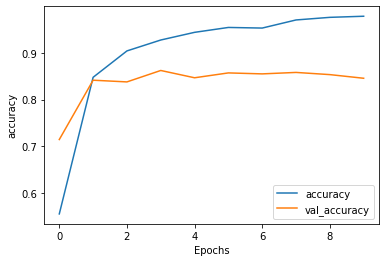

In [ ]:
plot_graphs(history, 'accuracy')

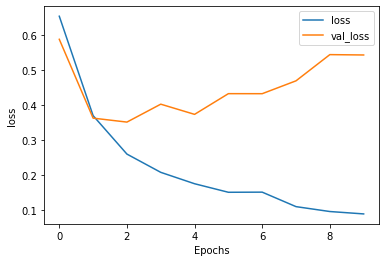

In [ ]:
plot_graphs(history, 'loss')



# 4. Bidirectional RNN

### tf.keras.layers.Bidirectional 구조

![Image of Yaktocat](https://miro.medium.com/max/700/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

### 데이터 준비
- tf.Dataset 함수를 이용하여 shuffle 및 padded_batch를 통해 가장 긴 문서길이를 기준으로 padding 작업

[stackoverflow: Meaning of BUFFER_SIZE](https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

LSTM layer를 사용하기 때문에, 1D  Average Poolling을 사용하지 않고, 데이터 정보 손실 없이 network를 구성할 수 있다. 다만, 그만큼 학습해야하는 params의 수가 증가함을 확인할 수 있다.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 46s 117ms/step - loss: 0.6512 - accuracy: 0.5518 - val_loss: 0.4696 - val_accuracy: 0.7422
Epoch 2/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3414 - accuracy: 0.8548 - val_loss: 0.3395 - val_accuracy: 0.8594
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.2511 - accuracy: 0.9025 - val_loss: 0.3414 - val_accuracy: 0.8698
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.2128 - accuracy: 0.9193 - val_loss: 0.3412 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.1825 - accuracy: 0.9335 - val_loss: 0.3640 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 45s 115ms/step - loss: 0.1658 - accuracy: 0.9404 - val_loss: 0.3671 - val_accuracy: 0.8719
Epoch 7/10
391/391 [==============================] - 45s 114ms/step - loss: 0.1463 - accuracy: 0.9493 - val_loss: 0.3625 - val_ac

### 모델 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 51ms/step - loss: 0.4530 - accuracy: 0.8474
Test Loss: 0.45299798250198364
Test Accuracy: 0.8473600149154663


### 참고: 패딩&마스킹

위의 모델에서 사용된 학습 데이터와 테스트 데이터는 모두 zero padding가 적용되었다. 따라서, 신규 데이터에 대한 예측을 위해선, 사전에 padding 작업을 진행해야 올바른 예측 결과를 얻을 수 있다.

[tensorflow:Masking & Padding](https://www.tensorflow.org/guide/keras/masking_and_padding?hl=en)


In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  print(tf.expand_dims(encoded_sample_pred_text, 0))
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

tf.Tensor(
[[1.900e+01 2.700e+01 1.800e+01 2.724e+03 3.000e+00 1.900e+01 1.847e+03
  5.000e+00 1.000e+00 5.172e+03 8.000e+00 8.500e+01 6.100e+01 6.000e+00
  1.400e+01 5.620e+02 3.000e+00 1.200e+01 7.000e+01 5.050e+02 1.400e+01
  6.500e+01 7.975e+03]], shape=(1, 23), dtype=float32)
[[-0.01312565]]


In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

tf.Tensor(
[[1.900e+01 2.700e+01 1.800e+01 2.724e+03 3.000e+00 1.900e+01 1.847e+03
  5.000e+00 1.000e+00 5.172e+03 8.000e+00 8.500e+01 6.100e+01 6.000e+00
  1.400e+01 5.620e+02 3.000e+00 1.200e+01 7.000e+01 5.050e+02 1.400e+01
  6.500e+01 7.975e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]], shape=(1, 64), dtype=float32)
[[-0.32945326]]


### 학습 히스토리 확인

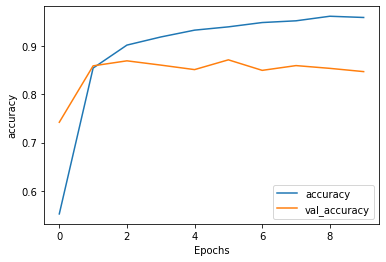

In [ ]:
plot_graphs(history, 'accuracy')

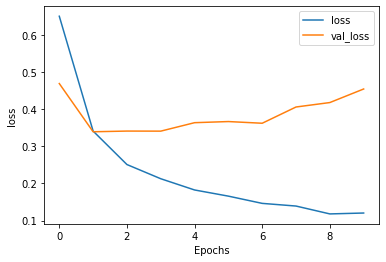

In [ ]:
plot_graphs(history, 'loss')